In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample
from astroML.datasets import fetch_LINEAR_geneva
from astropy.timeseries import TimeSeries
from astropy.table import Table
from astroML.time_series import MultiTermFit

# ZTF
from ztfquery import lightcurve

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme(style='white') # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#465BBB', '#3F8FCE', '#7ABBCE', '#3A3865', '#A82F43', '#612A37', '#DC5433', '#F29457']
b1 = '#465BBB'
b2 = '#3F8FCE'
b3 = '#7ABBCE'
b4 = '#3A3865'
black1 = '#22212A'
black2 = '#2D1E21'
or1 = '#A82F43'
or2 = '#612A37'
or3 = '#DC5433'
or4 = '#F29457'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('serif')
font.set_name('Andale Mono')
font.set_style('normal')
#font.set_size('normal')


%matplotlib inline 

In [3]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
from data_access import*
from helper import*
from RR_lyrae_params import*
from blazhko_analysis import*
from BE_plotting import*

# Blazhko analysis

---

*Authors: Ema Donev and dr. Ivezić*

In this notebook we tackle the selection of Blazhko candidates via an algorithm we designed, followed by visual analysis of all the candidates with their phase graphs, periodograms, total observation plot and a seasonal plot. We look for signs of amplitude or phase modulation, marks of the Blazhko effect.  

### DATA SETUP

In [4]:
#| code-fold: false
# LINEAR DATA
# ------------
dataL = fetch_LINEAR_sample(data_home='../inputs')

In [5]:
end = 'ffinal'

# DATA from previous notebook
lc_analysis = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")
rrlyrae = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

In [6]:
print(lc_analysis.shape)
lc_analysis.head()

(2857, 34)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,MainPeakZ,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score
0,29848,0.557020,0.557040,0.557030,1.000036,301,3.0,1.4,3.3,1.6,...,1.7952,1.7982,333.3333,0.2573,10.0729,0.37,0.00004,NaN,NaN,NaN
1,50402,0.643303,0.643294,0.643298,0.999986,284,0.6,0.7,0.6,0.7,...,1.5545,1.5918,26.8420,0.0027,8.9208,0.21,0.00001,NaN,NaN,NaN
2,62892,0.530776,0.530785,0.530780,1.000017,276,1.1,0.9,1.1,1.0,...,1.8840,1.9433,16.8634,0.0048,13.1609,0.02,0.00002,NaN,NaN,NaN
3,91437,0.674733,0.674737,0.674735,1.000006,177,2.8,1.3,2.8,1.3,...,1.4821,1.4849,355.8719,0.0233,16.1566,0.34,0.00001,NaN,NaN,NaN
4,95250,0.313870,0.313876,0.313873,1.000019,222,0.8,0.8,0.9,0.8,...,3.1860,3.1889,342.4658,0.0028,13.4528,0.02,0.00002,NaN,NaN,NaN


---

## ALGORITHM FOR SELECTION OF BLAZHKO STARS

Since there are 2857 RR Lyrae, all of which could be Blazhko stars, it is important to analyze all of them. However, it is inefficient to visually analyze each of the 2857 candidates, so we developed an algorithm to select a small subset of stars which have a high chance of being Blazhko stars. Of course, the algorithm isn't perfect (it cannot be), but it allows us to robustly and efficiently find many Blazhko stars without spending a large quantity of time looking through each example, where most of them are definitely not Blazhko.

The parameters in question for the scoring mechanism are chi2 values for LINEAR and ZTF data, period change and amplitude change. In order to determine the scoring limits, we plot the distribution of the chi2 and period change values, amplitude change limits are theoretically determined. 

In [7]:
plt.rcParams.update({
    'font.serif': 'Andale Mono',
    'font.family': 'serif'
})

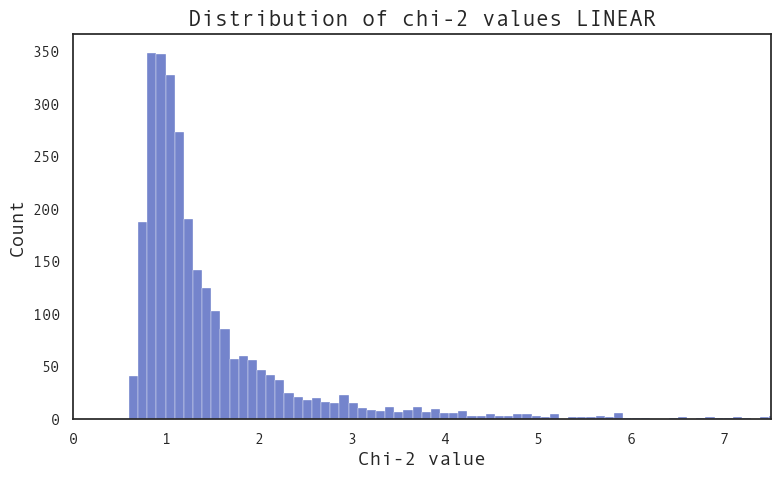

In [9]:
# CHI2 graph
# ============

plt.figure(figsize=(9,5))
sns.histplot(data=lc_analysis['L_chi2dofR'].to_numpy(),color=b1) # drawing a histogram of the distribution of measurements
plt.xlim([0,7.5])
plt.title('Distribution of chi-2 values LINEAR', fontproperties=font,fontsize=16)
plt.xlabel('Chi-2 value', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.savefig('../img_rsc/chi2_algorithmLIN.png', dpi=650)
plt.show()

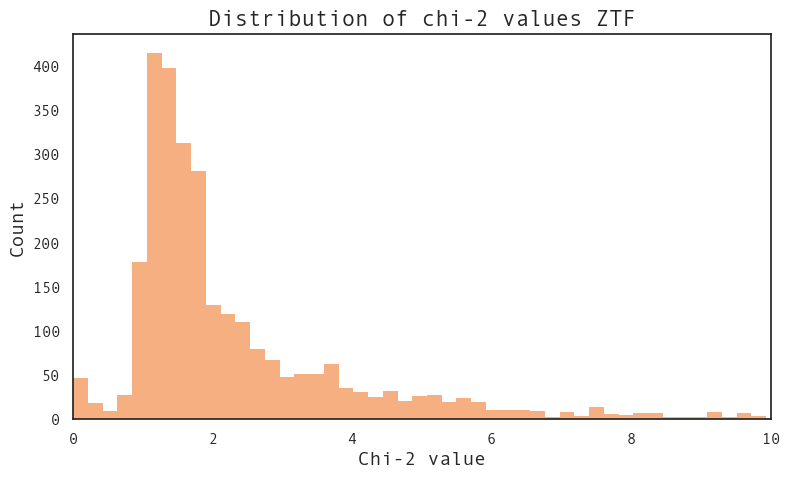

In [10]:
# CHI2 graph
# ============

plt.figure(figsize=(9,5))
sns.histplot(data=lc_analysis['Zchi2dofR'].to_numpy(),color=or4) # drawing a histogram of the distribution of measurements
plt.xlim([0,10])
plt.title('Distribution of chi-2 values ZTF', fontproperties=font,fontsize=16)
plt.xlabel('Chi-2 value', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.savefig('../img_rsc/chi2_algorithmZTF.png', dpi=650)
plt.show()

---

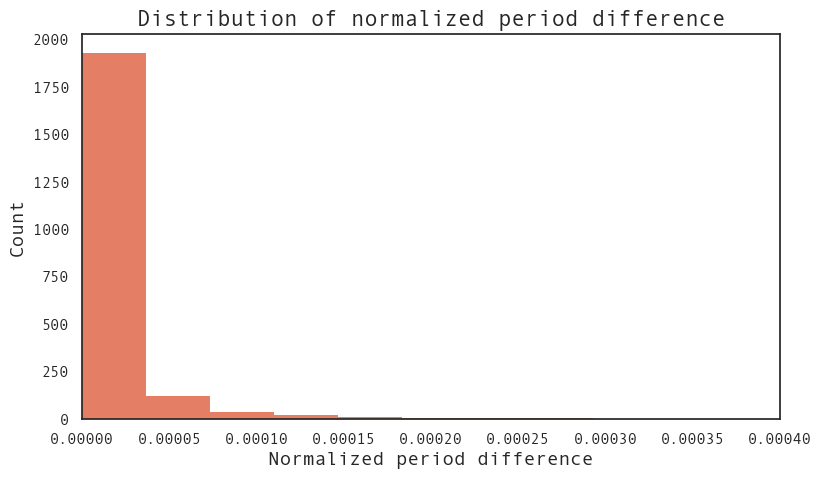

In [11]:
# Period difference graph
# ============

plt.figure(figsize=(9,5))
sns.histplot(data=lc_analysis['dP'].to_numpy(),color=or1) # drawing a histogram of the distribution of measurements
plt.xlim([0,0.0004])
plt.title('Distribution of normalized period difference', fontproperties=font,fontsize=16)
plt.xlabel('Normalized period difference', fontproperties=font, fontsize=14)
plt.ylabel('Count', fontproperties=font,fontsize=14)
plt.savefig('../img_rsc/period_diff_algorithm.png', dpi=650)
plt.show()

After analyzing the distribution graphs, we came up with the following "score-mechanism":
1. ### Removal of all stars with unrealistic data or an insufficient number of data points (250 for LINEAR and 40 for ZTF)
2. ### *Blazhko peak analysis*

    2.1 Removal of stars whose blazhko peak was a yearly/daily alias,

    2.2 Relative strength of peaks are below 0.05,

    2.3 Significance is below 5,
    
    2.4 Blazhko period is between 30 and 325 days.

    If a star satisfied the criteria of the periodogram analysis, they were immediately **blazhko stars**. However, if a star didn't pass the first test, it could still be selected using a score mechanism for its period difference (difference between LINEAR and ZTF period, divided by the mean period), amplitude or $\chi^2$. 

3. ### Score mechanism

    3.1 **Period difference**

    3.1.1 $0.00002 < dP < 0.00005$ worth 2 points,
        
    3.1.2 $dP > 0.00005$ worth 4 points.
        
    3.2 **$\chi^2$ analysis**

    **LINEAR**

    $1.8 < χ2 < 3.0$ worth 2 points,

    $χ2 > 3.0$ worth 3 points

    **ZTF**

    $2.0 < χ2 < 4.0$ worth 2,

    $χ2 > 4.0$ worth 3

    If both criteria were satisfied for 2 or 3 points, then 4 or 6 points were awarded, respectively.

    3.3 **Amplitude**
    
    $0.05 < amp < 0.15$ worth 1,

    $0.15 < ample < 2.00$ worth 2 points.

## Step 01: Blazhko candidate algorithm

---

In [13]:
blazhko_can = pd.DataFrame(())
blazhko_can = blazhko_determine(lc_analysis, blazhko_can)
blazhko_can.to_csv("../outputs/blazhko_can"+end+".csv", index=False)

In [8]:
blazhko_can = pd.read_csv("../outputs/blazhko_can"+end+".csv")
print(blazhko_can.shape)
blazhko_can.head(10)

(239, 35)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp
0,29848,0.557020,0.557040,0.557030,1.000036,301,3.0,1.4,3.3,1.6,...,1.7982,333.3333,0.2573,10.0729,0.37,0.00004,NaN,Z,6.0,period
1,158779,0.609207,0.609189,0.609198,0.999970,293,3.7,1.6,4.3,1.6,...,1.6444,350.2627,0.0123,16.5371,0.21,0.00003,NaN,Z,6.0,period
2,263541,0.558218,0.558221,0.558220,1.000005,270,15.8,2.9,16.2,3.0,...,1.8025,89.9685,0.0021,7.5968,0.18,0.00001,NaN,Z,7.0,amp
3,514883,0.557723,0.557737,0.557730,1.000025,289,5.3,1.7,5.4,1.6,...,1.7958,357.1429,0.0149,17.9476,0.17,0.00003,NaN,Z,7.0,period
4,523832,0.372376,0.372384,0.372380,1.000021,251,1.8,1.2,1.9,1.3,...,2.7122,37.3413,0.1528,6.3617,0.17,0.00002,Z,NaN,NaN,NaN
5,737951,0.357023,0.357023,0.357023,1.000000,273,6.0,2.2,6.0,2.2,...,2.8039,332.2259,0.0020,13.7006,0.09,0.00000,NaN,Z,6.0,amp
6,803829,0.595281,0.595286,0.595284,1.000008,270,8.7,2.3,9.7,2.7,...,1.6828,335.5705,0.0082,17.8498,0.43,0.00001,NaN,Z,10.0,amp
7,810169,0.465185,0.465212,0.465198,1.000058,289,6.0,2.1,8.2,2.3,...,2.2230,13.6082,0.0077,16.1490,0.02,0.00006,NaN,Z,12.0,period
8,880588,0.600138,0.600134,0.600136,0.999993,295,3.2,1.2,3.3,1.2,...,1.6736,136.4256,0.0109,14.7971,0.07,0.00001,L,NaN,NaN,NaN
9,924301,0.507503,0.507440,0.507472,0.999876,418,13.8,1.9,35.3,3.8,...,1.9763,178.4121,0.0219,18.8612,0.08,0.00012,NaN,Z,10.0,period


# Step 02: Visual analysis

This process was conducted in 4 phases:
1. ### The phased graph
Firstly, the shape and noisiness of the phased light curves were examined. If the light curve had the correct shape, there wasn't too much noise ($\chi^2$ wasn't too high) and there appeared to be smearing of the phased light curve ( a sign of modulation ), the light curve passed the first phase.

2. ### The periodogram
Secondly, the correctness of the algorithm in recognizing the blazhko frequency was looked at. If the blazhko peaks are right next to the yearly alias and not statistically significant, or if the algorithm detected a false signal, the light curve wouldn't pass this phase.

3. ### The full data
Thirdly, the general shape of the light curve was looked at. If the data showed a wave-like pattern, it would indicate the presence of amplitude modulation.

4. ### Seasons of observation
Finally, the most important phase, where we analyzed the light curve fit for each observation season, comparing how the light curve changed depending on the phased and normalized graph. We look for a translation in the x-coordinate, or a *phase modulation*, or if the width of the light curve changes during seasons, we found *amplitude modulation*.

A star can satisfy all 4 criteria, the first and final stage, or just the second stage to be considered a Blazhko star.

---

We split up our 239 candidates into 5 robust categories for more efficient visual analysis:
1. ZTF periodogram group
2. LINEAR periodogram group
3. ZTF chi2 group
4. LINEAR chi2 group
5. all stars which aren't part of the other 4 groups

In [ ]:
# ZTF PERIODOGRAM
# =================
ztf_per = category_analysis(blazhko_can, fits, periodogr, ztf_data, dataL, 'ztf_periodogram',id_list=None,parameter='IndicatorType', value='Z')

In [ ]:
blazhko_analyzer = ztf_per.get_save_data()
end = 'ztf_periodogram'
blazhko_analyzer.to_csv("../outputs/blazhko_list_"+end+".csv", index=False)

print(blazhko_analyzer.shape)

In [ ]:
# LINEAR PERIODOGRAM
# ======================
linear_per = category_analysis(blazhko_can, fits, periodogr, ztf_data, dataL, 'linear_periodogram',id_list=None,parameter='IndicatorType', value='L')

In [ ]:
blazhko_analyzerl = linear_per.get_save_data()
end = 'linear_periodogram'
blazhko_analyzerl.to_csv("../outputs/blazhko_list_"+end+".csv", index=False)

print(blazhko_analyzerl.shape)

In [ ]:
# ZTF CHI2
# ==========
ztf_chi = category_analysis(blazhko_can, fits, periodogr, ztf_data, dataL, 'ztf_chi',id_list=None,parameter='ChiType', value='Z')

In [ ]:
blazhko_analyzerzc = ztf_chi.get_save_data()
end = 'ztf_chi'
blazhko_analyzerzc.to_csv("../outputs/blazhko_list_"+end+".csv", index=False)

print(blazhko_analyzerzc.shape)

In [ ]:
# LINEAR CHI2
# ==========
linear_chi = category_analysis(blazhko_can, fits, periodogr, ztf_data, dataL, 'linear_chi',id_list=None,parameter='ChiType', value='L')

In [ ]:
blazhko_analyzerlc = linear_chi.get_save_data()
end = 'linear_chi'
blazhko_analyzerlc.to_csv("../outputs/blazhko_list_"+end+".csv", index=False)

print(blazhko_analyzerlc.shape)

In [ ]:
# OTHER
# =======
be_other = blazhko_can[(blazhko_can['IndicatorType']!= 'Z') & (blazhko_can['IndicatorType']!= 'L')&(blazhko_can['ChiType']!='Z')&(blazhko_can['ChiType']!='L')]
be_other = be_other.reset_index(drop=True)
print(be_other.shape)
be_other.head()

In [ ]:
BE_candidates_other = category_analysis(be_other, fits, periodogr, ztf_data, dataL, 'other')

In [ ]:
blazhko_analyzerother = BE_candidates_other.get_save_data()
end = 'other'
blazhko_analyzerother.to_csv("../outputs/blazhko_list_"+end+".csv", index=False)

print(blazhko_analyzerother.shape)

---

In [ ]:
BE_LIST = list(blazhko_analyzerlc['LINEAR id']) + list(blazhko_analyzerzc['LINEAR id']) + list(blazhko_analyzerl['LINEAR id']) + list(blazhko_analyzer['LINEAR id']) + list(blazhko_analyzerother['LINEAR id'])
BE_LIST = set(BE_LIST)
print(len(BE_LIST))

In [49]:
print(*BE_LIST, sep=', ')

9979905, 7279621, 1876491, 5592590, 23135759, 2455568, 16991760, 21488669, 21874209, 3140139, 9532981, 523832, 22959674, 158779, 1390653, 7580734, 10503746, 10662468, 8610884, 7283275, 2122319, 8799313, 2248787, 1240665, 1748058, 3219035, 3048546, 2243683, 3294319, 2397296, 1736308, 2936953, 7048826, 2041979, 6651516, 6819457, 3036295, 24020106, 9852554, 2892940, 924301, 1435279, 1092244, 2766997, 29848, 17544856, 5931160, 3437725, 737951, 22244513, 3196582, 4101289, 17247918, 9961135, 2334384, 5272753, 3183285, 2812086, 22828215, 810169, 22980793, 4586691, 1212611, 7827663, 8311517, 6967017, 11215595, 4320492, 17275627, 7846640, 1882354, 9236215, 2414841, 8343291, 23653629, 10030349, 2742032, 7254801, 7344401, 10814742, 9063194, 23898397, 2653982, 17185566, 7811366, 8907563, 1307948, 2075949, 9968431, 23596342, 19775800, 8222011, 21806402, 514883, 4804945, 23148883, 8331094, 9918809, 10260828, 10420063, 8036191, 1857382, 2229607, 1448299, 3196780, 22518636, 2612592, 263541, 9449335, 7

>  
> In total we have 136 Blazhko stars!!
> 

---

In [50]:
FINAL_BE_CATALOGUE = pd.DataFrame()
FINAL_BE_CATALOGUE = pd.concat([FINAL_BE_CATALOGUE, blazhko_analyzer.reset_index(drop=True)],ignore_index=True, axis=0)
FINAL_BE_CATALOGUE = pd.concat([FINAL_BE_CATALOGUE, blazhko_analyzerzc.reset_index(drop=True)],ignore_index=True, axis=0)
FINAL_BE_CATALOGUE = pd.concat([FINAL_BE_CATALOGUE, blazhko_analyzerl.reset_index(drop=True)],ignore_index=True, axis=0)
FINAL_BE_CATALOGUE = pd.concat([FINAL_BE_CATALOGUE, blazhko_analyzerlc.reset_index(drop=True)],ignore_index=True, axis=0)
FINAL_BE_CATALOGUE = pd.concat([FINAL_BE_CATALOGUE, blazhko_analyzerother.reset_index(drop=True)],ignore_index=True, axis=0)

print(FINAL_BE_CATALOGUE.shape)
FINAL_BE_CATALOGUE.head()

(136, 35)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp
0,523832,0.372376,0.372384,0.372380,1.000021,251,1.8,1.2,1.9,1.3,...,2.7122,37.3413,0.1528,6.3617,0.17,0.00002,Z,NaN,NaN,NaN
1,1240665,0.632528,0.632522,0.632525,0.999991,468,25.2,3.0,25.4,2.9,...,1.5865,182.3154,0.0570,15.9957,0.00,0.00001,Z,NaN,NaN,NaN
2,1736308,0.555848,0.555843,0.555846,0.999991,372,2.9,1.3,3.0,1.2,...,1.8264,36.6367,0.0529,5.6501,0.11,0.00001,Z,NaN,NaN,NaN
3,2669011,0.591153,0.591151,0.591152,0.999997,450,2.4,1.1,2.3,1.1,...,1.7015,101.2146,0.0751,6.5360,0.16,0.00000,Z,NaN,NaN,NaN
4,2742032,0.629676,0.629692,0.629684,1.000025,514,1.8,0.9,1.9,1.0,...,1.5956,133.2445,0.0602,7.4751,0.34,0.00003,Z,NaN,NaN,NaN


In [51]:
FINAL_BE_CATALOGUE.to_csv('../outputs/FINAL_BE_CATALOGUE.csv', index=False)

---

# VISUALIZATION OF RESULTS

In [9]:
FINAL_BE_CATALOGUE = pd.read_csv('../outputs/FINAL_BE_CATALOGUE.csv')

In [12]:
SHOWCASE_Catalogue1 = pd.DataFrame()
SHOWCASE_Catalogue1['LINEAR\nID'] = FINAL_BE_CATALOGUE['LINEAR id'].astype(str)
SHOWCASE_Catalogue1['LINEAR\nperiod'] = FINAL_BE_CATALOGUE['Plinear']
SHOWCASE_Catalogue1['ZTF\nperiod'] = FINAL_BE_CATALOGUE['Pztf']
SHOWCASE_Catalogue1['LINEAR\nchi-2'] = FINAL_BE_CATALOGUE['L_chi2dofR']
SHOWCASE_Catalogue1['ZTF\nchi-2'] = FINAL_BE_CATALOGUE['Zchi2dofR']
SHOWCASE_Catalogue1['LINEAR\namplitude'] = FINAL_BE_CATALOGUE['Lampl']
SHOWCASE_Catalogue1['ZTF \namplitude'] = FINAL_BE_CATALOGUE['Zampl']
SHOWCASE_Catalogue1['LINEAR\nmain\nfrequency'] = FINAL_BE_CATALOGUE['MainPeakL']
SHOWCASE_Catalogue1['LINEAR\nblazhko\nfrequency'] = FINAL_BE_CATALOGUE['BlazhkoPeakL']
SHOWCASE_Catalogue1['ZTF main\nfrequency'] = FINAL_BE_CATALOGUE['MainPeakZ']
SHOWCASE_Catalogue1['ZTF blazhko\nfrequency'] = FINAL_BE_CATALOGUE['BlazhkoPeakZ']
SHOWCASE_Catalogue1['LINEAR\nblazhko\nperiod'] = FINAL_BE_CATALOGUE['BlazhkoPeriodL']
SHOWCASE_Catalogue1['ZTF blazhko\nperiod'] = FINAL_BE_CATALOGUE['BlazhkoPeriodZ']

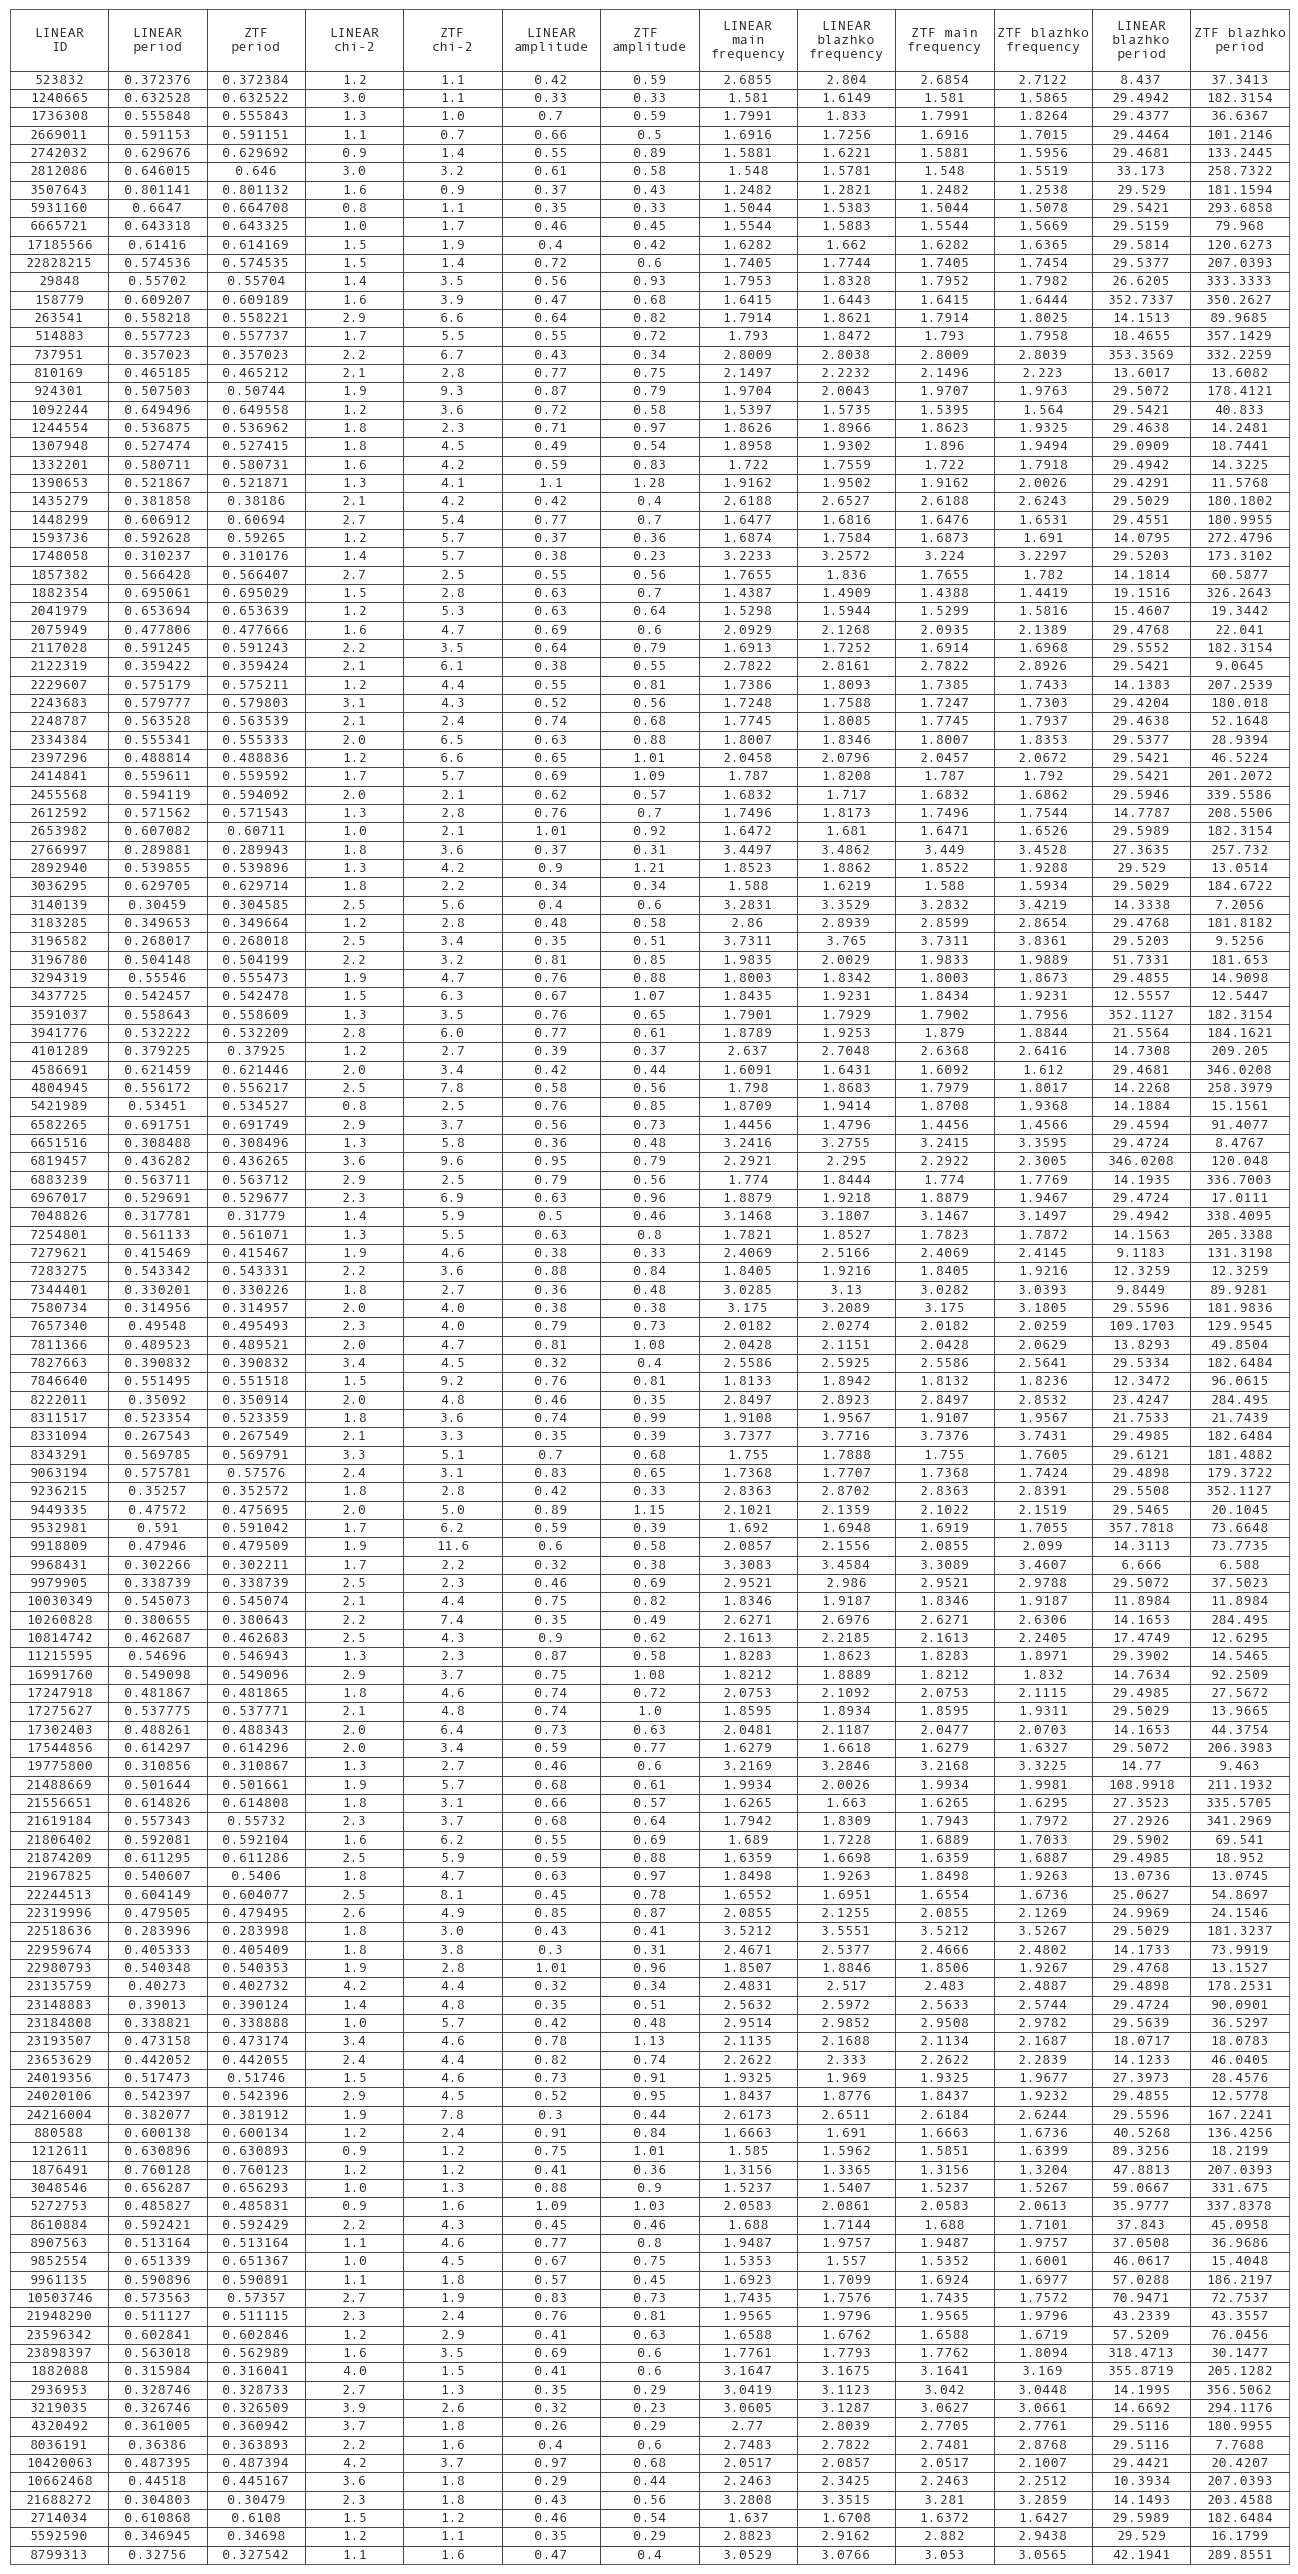

In [14]:
plt.style.use('ggplot')  
fig, ax = plt.subplots(figsize=(15, 8))  

ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=SHOWCASE_Catalogue1.values, colLabels=SHOWCASE_Catalogue1.columns, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)  
table.scale(1.1, 1.1)  

header_row = 0  
for col in range(len(SHOWCASE_Catalogue1.columns)):
    cell = table[header_row, col]
    cell.set_height(0.1)
    
# Save the figure
plt.savefig('../img_rsc/final_table.png', dpi=650, bbox_inches = 'tight')  
plt.show()

In [17]:
incidence_rate = SHOWCASE_Catalogue1.shape[0]/2914
print(f'The incidence rate of Blazhko stars in our sample of stars is:{round(incidence_rate*100, 2)}%')

The incidence rate of Blazhko stars in our sample of stars is:4.67%


In [18]:
algorithm_hit_rate = SHOWCASE_Catalogue1.shape[0]/blazhko_can.shape[0]
print(f'The hit rate of the algorithm is:{round(algorithm_hit_rate*100, 2)}%')

The hit rate of the algorithm is:56.9%


---

# Next...

Final analysis of newfound Blazhko stars!